# Project: Investigate the European Soccer Database

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

In this project, I am going to perform data analysis on a <a href="https://www.kaggle.com/hugomathien/soccer/data">soccer database</a>. This database contains information of:<br>
- +25,000 matches
- +10,000 players
- 11 European Countries with their lead championship
- Seasons 2008 to 2016
- Players and Teams' attributes* sourced from EA Sports' FIFA video game series, including the weekly updates
- Team line up with squad formation (X, Y coordinates)
- Betting odds from up to 10 providers
- Detailed match events (goal types, possession, corner, cross, fouls, cards etc...) for +10,000 matches

I will focus on investigating the players and their associated attributes.

Questions that I will be pondering upon include: <br>
1. Do players use left foot have greater free kick accuracy? Or do they actually have the same accuracy?
2. Are there any relationships between height and heading accuracy?
3. Are there any relationships between players' age and overall rating?

In [1]:
### Let's first load up all the packages that are necessary for the analysis.

# load all necessary packages for the data analysis
from sqlalchemy import create_engine
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style(style="darkgrid")

# the magic keywords for visualizing the plots
%matplotlib inline

<a id='wrangling'></a>
## Data Wrangling

The data set is stored in a SQLite database, and I am going to use the ORM, SQLAlchemy, to retrieve the data. For the sake of convenience and flexibility, I am going to turn all the retrieved data into Pandas Dataframes; so I get to leverage the maneuvers provided by the loaded libraries (Packages).

Steps that I am going to take: <br>
1. Create an interface to interact with the database
2. Retrieve the data, which should be in the form of multiple tables
3. Turn the tables into Pandas Dataframes
3. Inspect the data for cleanliness and tidiness
4. Trim and consolidate the data for further analysis

### General Properties

In [2]:
### Let's see what tables are included in the database by creating an interface (Engine).

# create an engine as an interface to interact with the database
engine = create_engine('sqlite:///dataset/database.sqlite')

# create a table object for the tables identified in the database
tables_in_db = engine.table_names()

# sanity check on the table names
print(tables_in_db)

['Country', 'League', 'Match', 'Player', 'Player_Attributes', 'Team', 'Team_Attributes', 'sqlite_sequence']


In [3]:
### Let's create a function so we get to retrieve the tables identified in the database.

# create a function that turns the tables into Pandas DataFrames stored in a dictionary
def df_sql_table(list_of_tables):
    """Read SQL tables and turn them into DataFrames."""
    
    # these will be the values that correspond to the dictionary's keys (Table names)
    table_df = []
    
    # a for loop to read all the tables identified in the database into Pandas Dataframes
    for table in list_of_tables:
        df = pd.read_sql_table(table, engine, parse_dates=True)
        # append each DataFrame to the list initiated
        table_df.append(df)
    
    # zip the labels and DataFrames
    zipped = list(zip(list_of_tables, table_df))
    # turn the zipped object into a dictionary
    table_df_in_dict = dict(zipped)
    
    return table_df_in_dict

In [4]:
### Run the function so we can turn the tables into DataFrames.

# implement the function on the table object
data = df_sql_table(tables_in_db)

# sanity check on dictionary keys
print(data.keys())

dict_keys(['Country', 'League', 'Match', 'Player', 'Player_Attributes', 'Team', 'Team_Attributes', 'sqlite_sequence'])


In [5]:
### Inspect the loaded data for cleanliness and tidiness.

# conduct preliminary inspection on the data set
info_check = [i.info() for i in data.values()]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11 entries, 0 to 10
Data columns (total 2 columns):
id      11 non-null int64
name    11 non-null object
dtypes: int64(1), object(1)
memory usage: 256.0+ bytes
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11 entries, 0 to 10
Data columns (total 3 columns):
id            11 non-null int64
country_id    11 non-null int64
name          11 non-null object
dtypes: int64(2), object(1)
memory usage: 344.0+ bytes
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25979 entries, 0 to 25978
Columns: 115 entries, id to BSA
dtypes: float64(96), int64(9), object(10)
memory usage: 22.8+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11060 entries, 0 to 11059
Data columns (total 7 columns):
id                    11060 non-null int64
player_api_id         11060 non-null int64
player_name           11060 non-null object
player_fifa_api_id    11060 non-null int64
birthday              11060 non-null object
height                11060 non-null i

From the info_check, we can see that the data sets are generally pretty clean and tidy, and there are not many missing values (With a few exceptions). Nonetheless, they can be further tailored to fit the purpose of the analysis.

A few tweaks I am going to do:
1. For some columns, change the object datatype (string in this case) to category datatype to reduce memory usage
2. For the columns with numeric datatype and a few missing values, use the mean to fill the missing values
3. Drop the columns with too many missing values
4. Drop the columns that are not necessary for the analysis

### Data Cleaning 

This is such a large data set in which contains way more inforamtion than I need; so I am going to only focus on tailoring the players' tables which I need for the analysis:
1. Player
2. Player_Attributes

My strategy is to first clean them up, and further consolidate them by performing a merge.

In [6]:
### Drop redundant columns in the Player DataFrame.

# Drop the id and the player_fifa_api_id column
data['Player'].drop(['id', 'player_fifa_api_id'], axis=1, inplace=True)

In [7]:
### Check to see if there are any duplicates in the Player DataFrame.

# Check to see if there are any duplicates
print(data['Player'].duplicated().value_counts())

False    11060
dtype: int64


In [8]:
### Change the 3 columns in the Player_Attributes DataFrame to category type.

# A loop to change the datatype
for col in ['preferred_foot', 'attacking_work_rate', 'defensive_work_rate']:
    data['Player_Attributes'][col] = data['Player_Attributes'][col].astype('category')

In [9]:
### Fill and drop the NaN values in the Player_Attributes DataFrame.

# Fill the NaN values with the mean associated with the column
data['Player_Attributes'].fillna(data['Player_Attributes'].mean(), inplace=True)

# Drop the NaN values in non-numeric columns
data['Player_Attributes'].dropna(inplace=True)

# Make sure NaN values are all gone
data['Player_Attributes'].isnull().sum().any()

False

In [10]:
### Drop redundant columns in the Player_Attributes DataFrame.

# Drop the id and the player_fifa_api_id column
data['Player_Attributes'].drop(['id', 'player_fifa_api_id'], axis=1, inplace=True)

In [11]:
### Check to see if there are any duplicates in the Player_Attributes DataFrame.

# Check to see if there are duplicates
print(data['Player_Attributes'].duplicated().value_counts())

False    180748
dtype: int64


In [12]:
### Consolidate the players' data by merging them into one DataFrame.

# Create a consolidated DataFrame for players
player_stats = pd.merge(data['Player'], data['Player_Attributes'], on=['player_api_id'], how='inner')

In [13]:
### Create an age column for the player_stats Dataframe

# Import datetime package
from datetime import datetime

# Create a datetime object which reflects the current time
now = datetime.now()

# Change the players' birthday to datetime objects
player_stats['birthday'] = pd.to_datetime(player_stats['birthday'])

# Perform subtraction to get the player's age
player_stats['age'] = (now - player_stats['birthday']).astype('<m8[Y]')

# Sanity check
player_stats.head()

,player_api_id,player_name,birthday,height,weight,date,overall_rating,potential,preferred_foot,attacking_work_rate,...,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes,age
0,505942,Aaron Appindangoye,1992-02-29,182,187,2016-02-18 00:00:00,67.0,71.0,right,medium,...,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0,25.0
1,505942,Aaron Appindangoye,1992-02-29,182,187,2015-11-19 00:00:00,67.0,71.0,right,medium,...,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0,25.0
2,505942,Aaron Appindangoye,1992-02-29,182,187,2015-09-21 00:00:00,62.0,66.0,right,medium,...,48.0,65.0,66.0,69.0,6.0,11.0,10.0,8.0,8.0,25.0
3,505942,Aaron Appindangoye,1992-02-29,182,187,2015-03-20 00:00:00,61.0,65.0,right,medium,...,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0,25.0
4,505942,Aaron Appindangoye,1992-02-29,182,187,2007-02-22 00:00:00,61.0,65.0,right,medium,...,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0,25.0


Now we have our consolidated DataFrame ready: <br>
player_stats

<a id='eda'></a>
## Exploratory Data Analysis



### Question 1: Do players use left foot have greater free kick accuracy? Or do they actually have the same accuracy?

Let's first do some preliminary investigation on the distribution of preferred foot among players.

In [14]:
# Count the number of each group
player_stats.preferred_foot.value_counts()

right    136551
left      44197
Name: preferred_foot, dtype: int64

The number of left foot players are less than 1/3 of the number of right foot players. Let's visualize it in a pie chart to have a better idea.

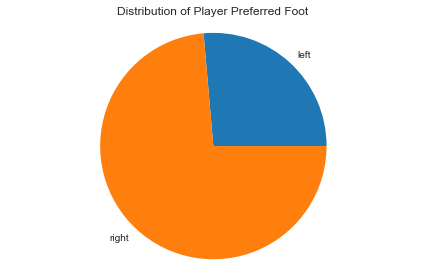

In [15]:
foot_dist = player_stats.groupby(['preferred_foot'])['free_kick_accuracy'].sum()
plt.pie(foot_dist, labels=foot_dist.index)
plt.title('Distribution of Player Preferred Foot')
plt.axis('equal')
plt.tight_layout()

Now let's see if there's a difference in free kick accuracy among these players.

In [16]:
# Group by preferred foot to get the mean of free kick accuracy
player_stats.groupby(['preferred_foot'])['free_kick_accuracy'].mean()

preferred_foot
left     53.284884
right    48.136872
Name: free_kick_accuracy, dtype: float64

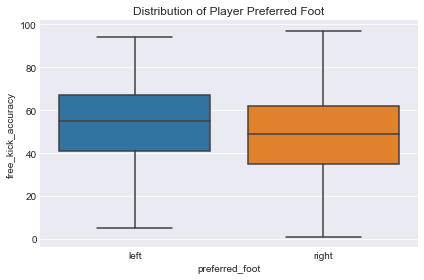

In [17]:
sns.boxplot(x='preferred_foot', y='free_kick_accuracy', data=player_stats)
plt.title('Distribution of Player Preferred Foot')
plt.tight_layout()

From the boxplot, we can see that the inter-quartile range (25th-75th) of left foot players is located higher than that of the right foot players. Most of the left foot players have a higher free kick accuracy than right foot players do.

From the first glance, it seems the left foot players do enjoy a higher free kick accuracy than the right foot players do, for about 5%.

Let's dig deeper by looking into their free kick accuracy individually. 

In [18]:
### Filter out the left foot players and right foot players separately from the Player Stats DataFrame.

# Create a DataFrame for the left foot players
left_foot = player_stats.query('preferred_foot == "left"')

# Create a DataFrame for the right foot players
right_foot = player_stats.query('preferred_foot == "right"')

I wonder if the free kick accuracy in each player group is actually normally distributed. 

Let's validate this by comparing the cumulative distribution function of the real data set and that of a sample data set which will have been normalized. If they in general overlap with each other, that player group is normally distributed.

In [19]:
### Create a ECDF function for plotting data sets

# The ECDF function
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""

    # Number of data points: n
    n = len(data)

    # x-data for the ECDF: x
    x = np.sort(data)

    # y-data for the ECDF: y
    y = np.arange(1, n+1) / n

    return x, y

Let's plot it for the left foot players.

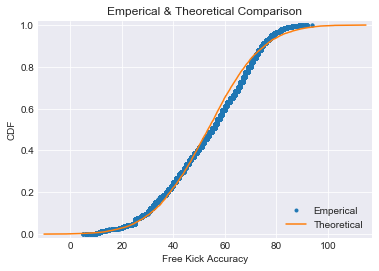

In [20]:
# Compute mean and standard deviation
mu_lf = np.mean(left_foot.free_kick_accuracy)
sigma_lf = np.std(left_foot.free_kick_accuracy)

# Sample out of a normal distribution with this mu and sigma
samples_lf = np.random.normal(mu_lf, sigma_lf, size=10000)

# Get the CDF of the samples and of the data
x_l_foot, y_l_foot = ecdf(left_foot.free_kick_accuracy)
x_l_theor, y_l_theor = ecdf(samples_lf)

# Plot the CDFs and show the plot
plt.plot(x_l_foot, y_l_foot, marker='.', linestyle='none')
plt.plot(x_l_theor, y_l_theor)
plt.title('Emperical & Theoretical Comparison')
plt.xlabel('Free Kick Accuracy')
plt.ylabel('CDF')
plt.legend(('Emperical', 'Theoretical'), loc='lower right')
plt.margins(0.02)
plt.show()

The curves generally overlay nicely, which implies that the free kick accuracy of the left foot players is normally distributed.

Now let's do the same thing for the right foot players.

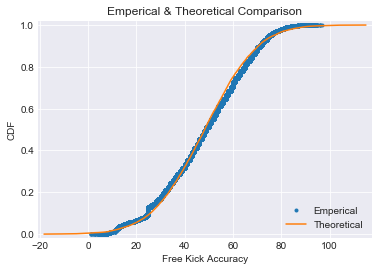

In [21]:
# Compute mean and standard deviation
mu_rf = np.mean(right_foot.free_kick_accuracy)
sigma_rf = np.std(right_foot.free_kick_accuracy)

# Sample out of a normal distribution with this mu and sigma
samples_rf = np.random.normal(mu_rf, sigma_rf, size=10000)

# Get the CDF of the samples and of the data
x_r_foot, y_r_foot = ecdf(right_foot.free_kick_accuracy)
x_r_theor, y_r_theor = ecdf(samples_rf)

# Plot the CDFs and show the plot
plt.plot(x_r_foot, y_r_foot, marker='.', linestyle='none')
plt.plot(x_r_theor, y_r_theor)
plt.title('Emperical & Theoretical Comparison')
plt.xlabel('Free Kick Accuracy')
plt.ylabel('CDF')
plt.legend(('Emperical', 'Theoretical'), loc='lower right')
plt.margins(0.02)
plt.show()

This group's curves overlay even nicer; so the free kick accuracy in both player groups are indeed normally distributed.

Now let's dig in deeper. Some people argue that there is no difference in free kick accuracy between left foot players and right foot players. In other words, the free kick accuracy of both groups is identically distributed.

This implies that the difference in mean that we observed above is just by chance becasue according to them, the mean of both groups should be the same. 

Or is it?

First, I wonder if we keep repeating the measurement (To see if there is a difference in mean), what would those potential values be/ lie between?

Second, I doubt if the argument claiming that the two player groups are identically distributed is legit.

Regarding the first point, I am going to validate it by using the technique of bootstrapping, in which I will generate bootstrap replicates to find the 95% confidence interval.

Regarding the second point, I am going to validate it by doing a hypothesis testing with the technique of permutation, in which I will generate permuted data to see if I could reject the null hypothesis, in this case, the two groups are identically distributed.

Let's first create a mean difference function and a bootstrap function for drawing bootstrap replicates.

In [22]:
### Create a mean difference function.

def diff_of_means(data_1, data_2):
    """Difference in means of two arrays."""

    # The difference of means of data_1, data_2: diff
    diff = np.mean(data_1) - np.mean(data_2)
    
    return diff

In [23]:
### Create a bootstrap function for drawing bootstrap replicates.

def bootstrap_replicate_1d(data, func):
    return func(np.random.choice(data, size=len(data)))

def draw_bs_reps(data, func, size=1):
    """Draw bootstrap replicates."""

    # Initialize array of replicates
    bs_replicates = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_replicates[i] = bootstrap_replicate_1d(data, func)

    return bs_replicates

In [24]:
# Compute the difference of the means
mean_diff = diff_of_means(left_foot.free_kick_accuracy, right_foot.free_kick_accuracy)

# Get bootstrap replicates of means
bs_replicates_lf = draw_bs_reps(left_foot.free_kick_accuracy, np.mean, 10000)
bs_replicates_rf = draw_bs_reps(right_foot.free_kick_accuracy, np.mean, 10000)

# Compute samples of difference of means
bs_diff_replicates = bs_replicates_lf - bs_replicates_rf

# Compute 95% confidence interval
conf_int = np.percentile(bs_diff_replicates, [2.5, 97.5])

# Print the results
print('Difference of means =', mean_diff, '%')
print('95% confidence interval =', conf_int)

Difference of means = 5.14801165142665 %
95% confidence interval = [ 4.96551105  5.33505009]


We can see that the emperical difference obtained from our real data set indeed lies between the 95% confidence interval.

Now let's do the hypothesis testing. 

The null hypothesis here is:
The free kick accuracy of left foot players and right foot players are identically distributed

Let's first create a permutation function.

In [25]:
### Create a permutation function for drawing permuted replicates.

def permutation_sample(data1, data2):
    """Generate a permutation sample from two data sets."""

    # Concatenate the data sets: data
    data = np.concatenate((data1, data2))

    # Permute the concatenated array
    permuted_data = np.random.permutation(data)

    # Split the permuted array into two
    perm_sample_1 = permuted_data[:len(data1)]
    perm_sample_2 = permuted_data[len(data1):]

    return perm_sample_1, perm_sample_2

def draw_perm_reps(data_1, data_2, func, size=1):
    """Generate multiple permutation replicates."""

    # Initialize array of replicates
    perm_replicates = np.empty(size)

    for i in range(size):
        # Generate permutation sample
        perm_sample_1, perm_sample_2 = permutation_sample(data_1, data_2)

        # Compute the test statistic
        perm_replicates[i] = func(perm_sample_1, perm_sample_2)

    return perm_replicates

Let's plot the ECDF of the permuted samples distribution to have a glance.

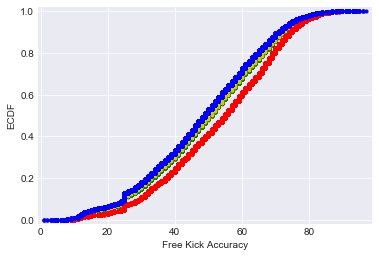

In [26]:
for i in range(50):
    # Generate permutation samples
    perm_sample_1, perm_sample_2 = permutation_sample(left_foot.free_kick_accuracy, right_foot.free_kick_accuracy)


    # Compute ECDFs
    x_ps_1, y_ps_1 = ecdf(perm_sample_1)
    x_ps_2, y_ps_2 = ecdf(perm_sample_2)

    # Plot ECDFs of permutation sample
    plt.plot(x_ps_1, y_ps_1, marker='.', linestyle='none',
                 color='green', alpha=0.02)
    plt.plot(x_ps_2, y_ps_2, marker='.', linestyle='none',
                 color='yellow', alpha=0.02)

# Create and plot ECDFs from original data
x_1, y_1 = ecdf(left_foot.free_kick_accuracy)
x_2, y_2 = ecdf(right_foot.free_kick_accuracy)
plt.plot(x_1, y_1, marker='.', linestyle='none', color='red')
plt.plot(x_2, y_2, marker='.', linestyle='none', color='blue')
plt.xlabel('Free Kick Accuracy')
plt.ylabel('ECDF')
plt.margins(0.02)

From the graph, we can see that the permuted samples (Green and yellow) are generally located within the two original data sets. This suggests that the hypothesis might not commensurate with the data sets, in this case, the two player groups might not be identically distributed.

Having said that, there seems to be some blurry area; so we cannot draw a conclusion yet.

Let's dig deeper by calculating the p-value with the permuted replicates, which in this case will be the difference in means.

In [27]:
# Compute difference of mean impact force from experiment
empirical_diff_means = diff_of_means(left_foot.free_kick_accuracy, right_foot.free_kick_accuracy)

# Draw 10,000 permutation replicates
perm_replicates = draw_perm_reps(left_foot.free_kick_accuracy, right_foot.free_kick_accuracy,
                                 diff_of_means, size=10000)

# Compute p-value
p = np.sum(perm_replicates >= empirical_diff_means) / len(perm_replicates)

# Print the result
print('p-value =', p)

p-value = 0.0


The p-value is so small that is almost 0. This suggests that under the assumption of the player groups are identically distributed is true, the probability we would obtain a difference in mean, in this case 5.15%, is pretty much 0%.

This is statistically significant; hence, we reject the null hypothesis. 

### Question 2: Are there any relationships between height and heading accuracy?

Now let's move onto investigating the relationship between height and heading accuracy. 

I'd like to first check the distribution of heights.

In [28]:
# Count the number of each age
player_stats.height.value_counts()

182    31632
177    23821
180    22440
187    21468
185    21003
175    19288
190    10843
172     8778
193     8002
170     7028
195     2102
167     1952
165      943
198      926
200      160
162      152
203      136
160       50
208       14
157       10
Name: height, dtype: int64

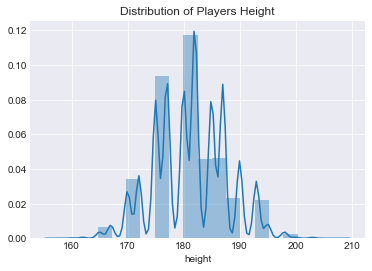

In [29]:
### Univariate distribution for height.

# Plot the distribution for height
sns.distplot(player_stats.height, bins=20, hist=True)
plt.title('Distribution of Players Height')

From the graph, we cannot really tell if the height is normally distributed; so let's compare the emperical and theoretical ECDF.

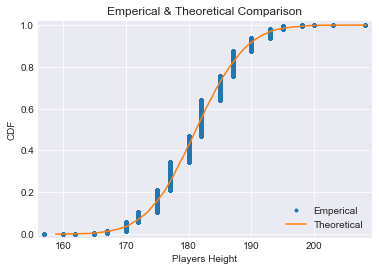

In [30]:
# Compute mean and standard deviation
mu_height = np.mean(player_stats.height)
sigma_height = np.std(player_stats.height)

# Sample out of a normal distribution with this mu and sigma
samples_height = np.random.normal(mu_height, sigma_height, size=10000)

# Get the CDF of the samples and of the data
x_height, y_height = ecdf(player_stats.height)
x_height_theor, y_height_theor = ecdf(samples_height)

# Plot the CDFs and show the plot
plt.plot(x_height, y_height, marker='.', linestyle='none')
plt.plot(x_height_theor, y_height_theor)
plt.title('Emperical & Theoretical Comparison')
plt.xlabel('Players Height')
plt.ylabel('CDF')
plt.legend(('Emperical', 'Theoretical'), loc='lower right')
plt.margins(0.02)
plt.show()

For the sake of better visualization, I am going to create a percentile object which stores the 2.5, 25, 50 ,75, and 97.5 percentiles for visualization afterwards.

In [31]:
# Plug in the heights
x_height, y_height = ecdf(player_stats['height'])

# Specify array of percentiles
percentiles = np.array([2.5, 25, 50 ,75, 97.5])

# Compute percentiles
ptiles_height = np.percentile(player_stats['height'], percentiles)

print(ptiles_height)

[ 170.  177.  182.  185.  193.]


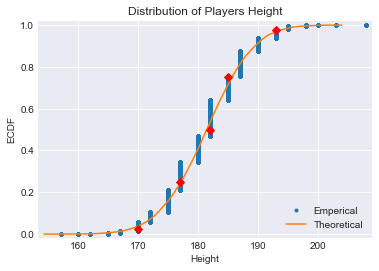

In [32]:
# Compute mean and standard deviation
mu_height = np.mean(player_stats.height)
sigma_height = np.std(player_stats.height)

# Sample out of a normal distribution with this mu and sigma
samples_height = np.random.normal(mu_height, sigma_height, size=10000)

# Get the CDF of the samples and of the data
x_height, y_height = ecdf(player_stats.height)
x_height_theor, y_height_theor = ecdf(samples_height)

# Compute percentiles
ptiles_height = np.percentile(player_stats.height, percentiles)

# Plot the ECDF
plt.plot(x_height, y_height, marker='.', linestyle='none')
plt.plot(x_height_theor, y_height_theor)
plt.plot(ptiles_height, percentiles/100, marker='D', color='red', linestyle='none')
plt.title('Distribution of Players Height')
plt.xlabel('Height')
plt.ylabel('ECDF')
plt.legend(('Emperical', 'Theoretical'), loc='lower right')
plt.margins(0.02)

Now we have a better idea. The curves in general overlay pretty nicely. It seems that players' heights are normally distributed.

182CM is the threshold (Median) of this data set. 

Now let's dig in and see if there is a correlation between height and heading accuracy.

Let's create a jointplot to grab a first glance.

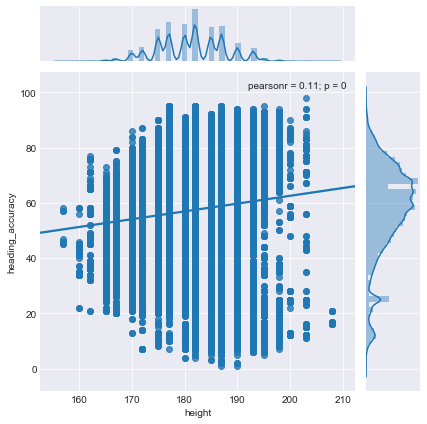

In [33]:
# A jointplot to visualize players' height against heading accuracy
sns.jointplot(x='height', y='heading_accuracy', data=player_stats, kind='reg')

In [34]:
### Create a function to get the correlation coefficient

# The correlatin coefficient function
def pearson_r(x, y):
    """Compute Pearson correlation coefficient between two arrays."""
    # Compute correlation matrix: corr_mat
    corr_mat = np.corrcoef(x,y)

    # Return entry [0,1]
    return corr_mat[0,1]

In [35]:
# Run the function on the variables
pearson_r(player_stats.height, player_stats.heading_accuracy)

0.10895266428856185

Although positive, the correlation is not that strong based on our real data set. 

Let's use bootstrapping to find the 95% confidence interval of the correlation. For this, we need to write a another function that boostraps in pairs and returns a single statistic because the statistical inference is now parametric (Correlation).

In [36]:
### Create a bootstrap function.

def draw_bs_pairs(x, y, func, size=1):
    """Perform pairs bootstrap for single statistic."""

    # Set up array of indices to sample from
    inds = np.arange(len(x))

    # Initialize replicates
    bs_replicates = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_inds = np.random.choice(inds, len(inds))
        bs_x, bs_y = x[bs_inds], y[bs_inds]
        bs_replicates[i] = func(bs_x, bs_y)

    return bs_replicates

In [37]:
# Run the function to draw bootstrap replicates of correlation
bs_replicates_heading = draw_bs_pairs(player_stats.height, player_stats.heading_accuracy, pearson_r, 1000)

# Get the 95% confidence interval
conf_int_heading = np.percentile(bs_replicates_heading, [2.5, 97.5])

print('Correlation between height and heading accuracy - 95% Confidence Interval:', conf_int_heading)

Correlation between height and heading accuracy - 95% Confidence Interval: [ 0.10347816  0.11432936]


The observed value, 0.11, in this case lies between the interval. Again, some people might argue that this is just by chance. 

So let's test if height and heading accuracy are independent to each other. 

To clarify, our null hypothesis is:
The heading accuracy of a given player is totally independent of his height

To test this, we will again use the technique of permutation, only this time we permute one variable and leave the other one fixed. This should simulate the hypothesis that the variables are independent of each other.

In [38]:
# Compute observed correlation
r_observed = pearson_r(player_stats.height, player_stats.heading_accuracy)

# Initialize permutation replicates: perm_replicates
perm_replicates = np.empty(10000)

# Draw replicates
for i in range(10000):
    # Permute height
    height_permuted = np.random.permutation(player_stats.height)

    # Compute Pearson correlation
    perm_replicates[i] = pearson_r(height_permuted, player_stats.heading_accuracy)

# Compute p-value
p = np.sum(perm_replicates >= r_observed) / len(perm_replicates)
print('p-value =', p)

p-value = 0.0


The p-value is so small that is almost 0. This suggests that under the assumption of height and heading accuracy are totally independent of each other is true, the probability we would obtain a correlation, in this case 0.11, is pretty much 0%.

This is statistically significant; hence, we reject the the null hypothesis.

### Question 3: Are there any relationships between players' age and overall rating?

Age is usually a big factor to consider when taking part in different activities, especially athletic ones (Sports).

Let's check the age range in this data set.

In [39]:
# Group by age
player_stats.groupby(['age'])['player_name'].count()

age
18.0        7
19.0      109
20.0      798
21.0     2147
22.0     3895
23.0     6262
24.0     8416
25.0     9903
26.0    12451
27.0    12993
28.0    13341
29.0    14609
30.0    14360
31.0    13476
32.0    11415
33.0    10829
34.0    10096
35.0     8246
36.0     7578
37.0     6386
38.0     4888
39.0     3125
40.0     2090
41.0     1432
42.0      907
43.0      460
44.0      221
45.0      139
46.0       86
47.0       58
48.0       12
49.0        9
51.0        4
Name: player_name, dtype: int64

The ages vary from 18 to 50 and converge to 30, with a few outliers.

The ages seem to be normally distributed. Let's plot them out to have a glance.

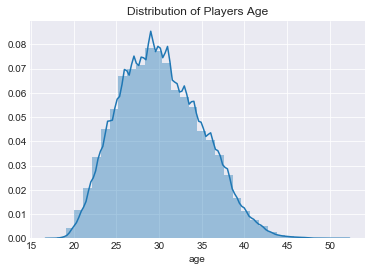

In [40]:
### Univariate distribution for age.

#Plot the distribution for age
sns.distplot(player_stats.age, bins=32, hist=True)
plt.title('Distribution of Players Age')

Let's double-check to see if the age is normally distributed by comparing the emperical and the theoretical ECDF.

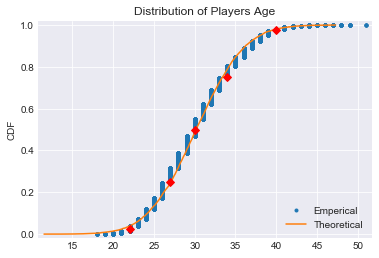

In [41]:
# Compute mean and standard deviation
mu_age = np.mean(player_stats.age)
sigma_age = np.std(player_stats.age)

# Sample out of a normal distribution with this mu and sigma
samples_age = np.random.normal(mu_age, sigma_age, size=10000)

# Get the CDF of the samples and of the data
x_age, y_age = ecdf(player_stats.age)
x_age_theor, y_age_theor = ecdf(samples_age)

# Compute percentiles
ptiles_age = np.percentile(player_stats.age, percentiles)

# Plot the CDFs and show the plot
plt.plot(x_age, y_age, marker='.', linestyle='none')
plt.plot(x_age_theor, y_age_theor)
plt.title('Emperical & Theoretical Comparison')
plt.plot(ptiles_age, percentiles/100, marker='D', color='red', linestyle='none')
plt.title('Distribution of Players Age')
plt.ylabel('CDF')
plt.legend(('Emperical', 'Theoretical'), loc='lower right')
plt.margins(0.02)
plt.show()

30 year-old is the threshold (Median) in this data set.

The normal distribution model fits the data set pretty much perfectly.

Let's see if there is a correlation between age and overall rating.

In [42]:
pearson_r(player_stats.age, player_stats.overall_rating)

0.27881901269813164

Although not very strong, there is indeed a positive relationship between age and overall rating. 

Let's further illustrate it in a jointplot.

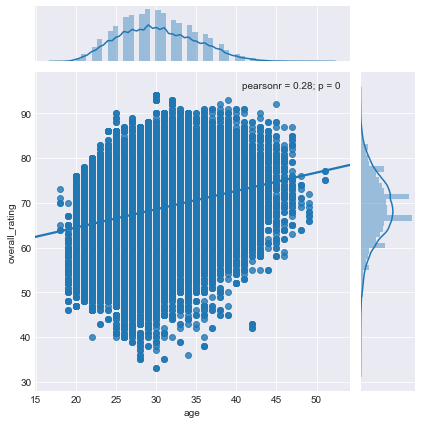

In [43]:
# A jointplot to visualize players' age against overall rating
sns.jointplot(player_stats['age'], player_stats['overall_rating'], kind='reg')

From the jointplot, we can see that as age goes up, overall rating in general also goes up.

Now let's find the 95% confidence internal of the correlation and test if age and overall rating are completely independent of each other like we did for height and heading accuracy.

In [44]:
# Run the function to draw bootstrap replicates of correlation
bs_replicates_or = draw_bs_pairs(player_stats.age, player_stats.overall_rating, pearson_r, 1000)

# Get the 95% confidence interval
conf_int_or = np.percentile(bs_replicates_or, [2.5, 97.5])

print('Correlation between age and overall rating - 95% Confidence Interval:', conf_int_or)

Correlation between age and overall rating - 95% Confidence Interval: [ 0.27447251  0.28321603]


In [45]:
# Compute observed correlation
r_observed_or = pearson_r(player_stats.age, player_stats.overall_rating)

# Initialize permutation replicates
perm_replicates = np.empty(10000)

# Draw replicates
for i in range(10000):
    # Permute age
    age_permuted = np.random.permutation(player_stats.age)

    # Compute Pearson correlation
    perm_replicates[i] = pearson_r(age_permuted, player_stats.overall_rating)

# Compute p-value
p = np.sum(perm_replicates >= r_observed_or) / len(perm_replicates)
print('p-value =', p)

p-value = 0.0


The p-value is so small that is almost 0. This suggests that under the assumption of age and overall rating are totally independent of each other is true, the probability we would obtain a correlation, in this case 0.28, is pretty much 0%.

This is statistically significant; hence, we reject the the null hypothesis.

<a id='conclusions'></a>
## Conclusions



From the EDA, we can draw quite a few conclusions. Nonetheless, there is still something that remains unclear in which further analysis needed to be conducted.

Question 1:<br>
Left foot players do possess higher free kick accuracy than right foot players do, and each group's free kick accuracy is normally distributed. Having said that, they are not identically distributed. In other words, the difference observed in the data set is not by chance. We validated this by running a hypothesis testing with the help of permutation. To clarify, this does not mean using left foot will directly increase free kick accuracy, and it remains unclear that why using left foot will casue a higher free kick accuracy.

Question 2:<br>
The heights of players are normally distributed. It is also concluded that height and heading accuracy are not totally independent of each other. We validated this by running hypothesis testing with the help of permutation. We also found the 95% confidence internal of the correlation in which our observed value lies between.

Questions 3:<br>
The ages of players are normally distributed. We found that age and overall rating are not completely independent of each other. We validated this by running hypothesis testing with the help of permutation. On top of that, we found the the 95% confidence internal of the correlation in which our observed value lies between.


As we can see, there is still quite a lot of area that remains unclear. Questions that we could ponder upon include:<br>
1. Should goal keepers be considered as a factor when evaluating free kick accuracy? Chances are goal keepers may find left foot players gestures harder to capture, which could potentially put left foot players in a better position for shooting.
2. Why is there a positive correlation between age and overall rating? And if age itself as an indicator of physical condition of players, shouldn't there be a negative correlation instead? One of the reasons to explain this is probably experience among players, which is also a factor that plays a very significant role in all kinds of activities including athletic ones (Sports).

In [46]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Investigate_a_Dataset.ipynb'])

0